In [2]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch
from tqdm import tqdm

from model import Net

%load_ext autoreload
%autoreload 2

Set hyper parameters

In [18]:
batch_size = 300
latent_dim = 2
lr = 0.001
NumOfContacts = 1431 # number of contacts in contact map


In [16]:
def compute_loss(dataloader,net,loss_func):
    
    loss = 0
    
    if torch.cuda.is_available():
        net.cuda()
    net.eval()
    
    n_batches = 0
    with torch.no_grad():
        for x in dataloader:
            n_batches+=1
            
            if torch.cuda.is_available():
                x = x.cuda()
            out = net(x)
            
            
            loss+= loss_func(out,x)
            
    loss = loss/n_batches      
    return loss

## Load the data: 

In [3]:
all_data = torch.FloatTensor(np.load('../dis_mat_325767.npy'))
# Dropbox location of the data: 
#all_data = torch.FloatTensor('https://www.dropbox.com/s/7zy3ezxhvv469cv/dis_mat_325767.npy?dl=0')

## Plot distance matrix 

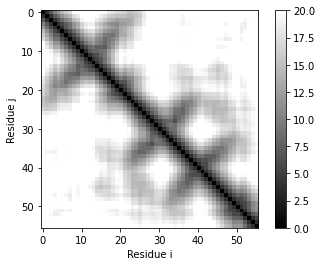

In [4]:
plt.imshow(torch.mean(all_data,dim=2),vmax=20,cmap='gray')
plt.xlabel('Residue i')
plt.ylabel('Residue j')
plt.colorbar()
plt.show()

## Reshape:

In [6]:

all_data_backup =all_data
all_data = torch.reshape(all_data,(56**2,99998))
all_data = all_data.T

In [7]:
# Make sure reshape worked
print(all_data.shape)
print(all_data_backup.shape)


torch.Size([99998, 3136])
torch.Size([56, 56, 99998])


Shuffle:

In [13]:
dd = all_data
idx = torch.randperm(dd.shape[0])

Split to training and validation:

In [15]:
len_data = all_data.shape[0]

training_ds = all_data[idx[:int(-0.3*len_data)],:] # first 70% of trajectory is for training
validation_ds = all_data[idx[int(-0.3*len_data):],:] # last 30% is for validation

print(training_ds.shape,validation_ds.shape)

torch.Size([69999, 3136]) torch.Size([29999, 3136])


Load the data, split to batches: 

In [19]:
training_dataloader = DataLoader(training_ds,batch_size)
validation_dataloader = DataLoader(validation_ds,batch_size)
loss_func = nn.MSELoss()

Initialize network and define optimizer:

In [21]:
net = Net()
optimizer = optim.Adam(net.parameters(), lr)

Compare example output data before training Auto Encoder

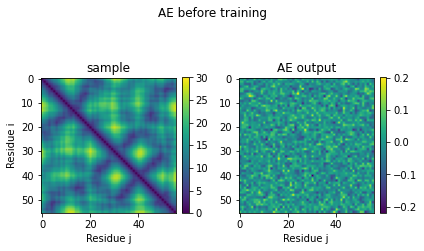

In [23]:
idx = 100
sample_data =torch.reshape(all_data[idx,:],(56,56))
decoded = net(all_data[idx,:]).data.numpy().reshape(56,56)

plt.subplot(1,2,1)
plt.imshow(torch.reshape(sample_data,(56,56)),label='sample',vmax = 30)
plt.title('sample')
plt.xlabel('Residue j')
plt.ylabel('Residue i')

#plt.colorbar()
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1,2,2)
plt.imshow(decoded,label='vae out')
plt.title('AE output')
plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel('Residue j')
plt.tight_layout()
plt.suptitle('AE before training')
plt.savefig('conformation_{}_sample_vs_vae_model_before_training.png'.format(idx),dpi=250)
plt.show()


Train:

In [24]:
from tqdm.notebook import tqdm
n_epochs = 30
use_gpu = True
device = torch.device('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')
net.to(device)

training_loss = []
validation_loss = []

for epoch in tqdm(range(n_epochs)):
    
    net.train() # put the net into "training mode"
    for x in training_dataloader:
        
        optimizer.zero_grad()
        
        x = x.to(device)
        out = net(x)
        
        loss = loss_func(out,x) # input is target
        
        loss.backward()  
        optimizer.step()
    # computing the loss is very expensive so compute only every 5 epochs
    if epoch % 5 == 0:
        net.eval() #put the net into evaluation mode
        training_loss.append(compute_loss(training_dataloader,net,loss_func))
        validation_loss.append(compute_loss(validation_dataloader,net,loss_func))
    


Plot loss of validation and training: 

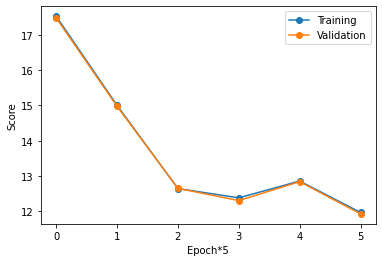

In [26]:
plt.plot(training_loss,'o-',label='Training')
plt.plot(validation_loss,'o-',label='Validation')
plt.xlabel('Epoch*5')
plt.ylabel('Score')
#plt.ylim(np.min(training_loss),500*np.min(training_loss))
plt.legend()
plt.show()

Save the model:

In [27]:
torch.save(net.state_dict(), 'trained_model.pt')

Load the saved model

In [28]:
net = Net()
net.load_state_dict(torch.load('trained_model.pt'))
net.eval()

Net(
  (enc): Encoder(
    (fc1): Linear(in_features=3136, out_features=400, bias=True)
    (fc2): Linear(in_features=400, out_features=50, bias=True)
    (fc3): Linear(in_features=50, out_features=20, bias=True)
    (fc4): Linear(in_features=20, out_features=2, bias=True)
    (relu): ReLU()
  )
  (dec): Decoder(
    (fc1): Linear(in_features=2, out_features=20, bias=True)
    (fc2): Linear(in_features=20, out_features=50, bias=True)
    (fc3): Linear(in_features=50, out_features=400, bias=True)
    (fc4): Linear(in_features=400, out_features=3136, bias=True)
    (relu): ReLU()
  )
)

Compare input to output after VA was trained:

(56, 56) (56, 56)


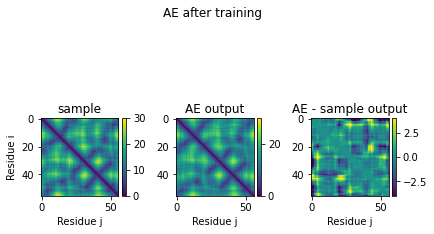

In [29]:
# compare example output data
idx = 100
sample_data =all_data[idx,:].data.numpy().reshape(56,56)
decoded  = net(all_data[idx,:])
decoded = decoded.data.numpy().reshape(56,56)
delta = decoded - sample_data
print(sample_data.shape,decoded.shape)

plt.subplot(1,3,1)
plt.imshow(sample_data,label='sample',vmax = 30)
plt.title('sample')
plt.xlabel('Residue j')
plt.ylabel('Residue i')

#plt.colorbar()
plt.colorbar(fraction=0.046, pad=0.04)


plt.subplot(1,3,2)
plt.imshow(decoded,label='vae out',vmax = 30)
plt.title('AE output')
plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel('Residue j')

plt.subplot(1,3,3)
plt.imshow(delta,label='vae out',vmin=-4, vmax = 4)
plt.title('AE - sample output')
plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel('Residue j')
plt.suptitle('AE after training')
plt.tight_layout()
plt.savefig('conformation_{}_sample_vs_model.png'.format(idx),dpi=250)
plt.show()

Get the latent space from the model:

In [30]:
latent=net(all_data,ret_latent=True)

Load the number of native contacts from the simulation output

In [31]:
Qdata = np.load('all_data_1000ts_interval.npy')
# Dropbox data: 
#Qdata = np.load('https://www.dropbox.com/s/0rpd1syufyw84mz/all_data_1000ts_interval.npy?dl=0')
Qdata= Qdata[:,:-2]

Plot the fraction of native contacts (Q) as a function of time.
Q has a defined physical meaning, so it is a good way to try to interpet what the AE learned from the data.

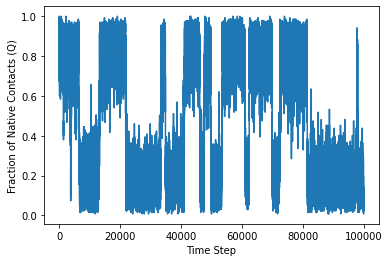

In [32]:
Qdata.shape
Q = np.sum(Qdata,axis=0)/137 # Normelize Q to be from 0 to 1
plt.plot(Q)
plt.xlabel('Time Step')
plt.ylabel('Fraction of Native Contacts (Q)')
plt.show()

## Interpetation:

Get indexes of folded and unfolded conformations:

In [33]:
fndx = np.argwhere(Q>0.5)
undx = np.argwhere(Q<=0.5)

Plot latent variable (LV) 1 against LV2, colored by folding status, to test if the cluster in different areas.

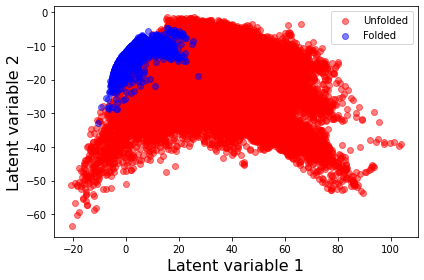

In [39]:
xxf = latent[fndx,0].data.numpy()
yyf = latent[fndx,1].data.numpy()

xxu = latent[undx,0].data.numpy()
yyu = latent[undx,1].data.numpy()

plt.scatter(xxu,yyu,color='red',label='Unfolded',alpha=0.5)
plt.scatter(xxf,yyf,color='blue',label='Folded',alpha=0.5)


plt.xlabel('Latent variable 1',fontsize = 16)
plt.ylabel('Latent variable 2',fontsize = 16)
plt.legend()
plt.tight_layout()
plt.show()


It is interesting that the folded conformations are more restricted in the latent space. 
Network may have learned structural features. 

Plot Q vs. LV1 and LV2:

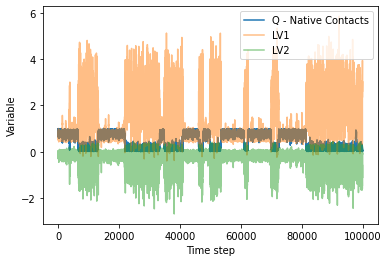

In [43]:
plt.plot(Q,label='Q - Native Contacts')
plt.plot((latent[:,0].data.numpy()+13)/20,label='LV1',alpha=0.5)
plt.plot((latent[:,1].data.numpy()+10)/20,label='LV2',alpha=0.5)
plt.xlabel('Time step')
plt.ylabel('Variable')
plt.legend()
plt.show()


Look for correlations between latent variables and Q: 

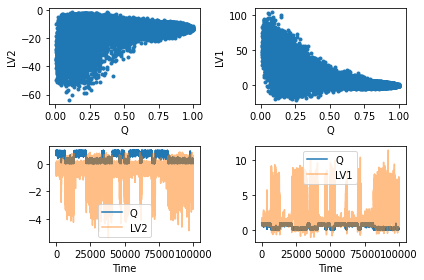

In [44]:
plt.subplot(2,2,1)
plt.plot(Q,latent[:,1].data.numpy(),'.',label='Q')
plt.xlabel('Q')
plt.ylabel('LV2')

plt.subplot(2,2,2)
plt.plot(Q,latent[:,0].data.numpy(),'.',label='Q')
plt.xlabel('Q')
plt.ylabel('LV1')

plt.subplot(2,2,3)

plt.plot(Q,label='Q')
#plt.plot((latent[:,0].data.numpy()+13)/10,label='LV1',alpha=0.5)
plt.plot((latent[:,1].data.numpy()+10)/10,label='LV2',alpha=0.5)
plt.xlabel('Time')
plt.legend()

plt.subplot(2,2,4)

plt.plot(Q,label='Q')
plt.plot((latent[:,0].data.numpy()+10)/10,label='LV1',alpha=0.5)
plt.xlabel('Time')
plt.legend()

plt.tight_layout()

plt.savefig('Interpetation.png',dpi=250)

# Now add variation, so it would be a VAE:

In [45]:
from VAE import VAE
vae = VAE()

In [46]:
def compute_loss_vae(dataloader,net,loss_func):
    
    loss = 0
    
    if torch.cuda.is_available():
        vae.cuda()
    vae.eval()
    
    n_batches = 0
    with torch.no_grad():
        for x in dataloader:
            n_batches+=1
            
            if torch.cuda.is_available():
                x = x.cuda()
            x_reco, mu, logvar = vae(x)
 #           out = net(x)
            
            
            loss+= loss_func(x_reco,x)
            
    loss = loss/n_batches      
    return loss

In [47]:
x_reco, mu, logvar = vae(all_data[idx,:])
#.data.numpy().reshape(56,56)
print(x_reco.shape)

torch.Size([1, 3136])


Compare example output data before training Variational Auto Encoder:

torch.Size([56, 56]) (56, 56)


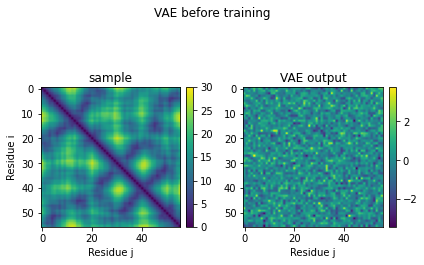

In [48]:
idx = 100
sample_data =torch.reshape(all_data[idx,:],(56,56))
x_reco, mu, logvar = vae(all_data[idx,:])
decoded = x_reco.data.numpy().reshape(56,56)
print(sample_data.shape,decoded.shape)

plt.subplot(1,2,1)
plt.imshow(torch.reshape(sample_data,(56,56)),label='sample',vmax = 30)
plt.title('sample')
plt.xlabel('Residue j')
plt.ylabel('Residue i')

#plt.colorbar()
plt.colorbar(fraction=0.046, pad=0.04)


plt.subplot(1,2,2)
plt.imshow(decoded,label='vae out')
plt.title('VAE output')
plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel('Residue j')
plt.suptitle('VAE before training')
plt.tight_layout()
plt.savefig('conformation_{}_sample_vs_vae_model_before_training_vae.png'.format(idx),dpi=250)
plt.show()

Train:

In [49]:
from tqdm.notebook import tqdm

optimizer = optim.Adam(vae.parameters(), lr)
n_epochs = 30
use_gpu = True
device = torch.device('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')
vae.to(device)

training_loss = []
validation_loss = []

for epoch in tqdm(range(n_epochs)):
    
    vae.train() # put the net into "training mode"
    for x in training_dataloader:
        
        optimizer.zero_grad()
        
        x = x.to(device)
        x_reco, mu, logvar = vae(x)
        
        loss = loss_func(x_reco,x) # input is target
        
        loss.backward()  
        optimizer.step()
    # computing the loss is very expensive so compute only every few epochs
    if epoch % 5 == 0:
        net.eval() #put the net into evaluation mode
        training_loss.append(compute_loss_vae(training_dataloader,vae,loss_func))
        validation_loss.append(compute_loss_vae(validation_dataloader,vae,loss_func))
    


Save model:

In [50]:
torch.save(vae.state_dict(), 'trained_model_vae.pt')

plot loss:

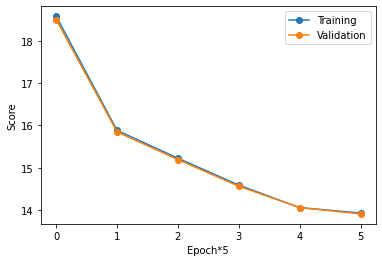

In [51]:
plt.plot(training_loss,'o-',label='Training')
plt.plot(validation_loss,'o-',label='Validation')
plt.xlabel('Epoch*5')
plt.ylabel('Score')
#plt.ylim(np.min(training_loss),500*np.min(training_loss))
plt.legend()
plt.show()

Compare example output data

(56, 56) (56, 56)


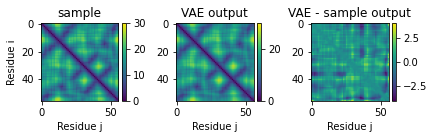

In [53]:
idx = 300
sample_data =all_data[idx,:].data.numpy().reshape(56,56)
decoded , mmuu, llogvar = vae(all_data[idx,:])
decoded = decoded.data.numpy().reshape(56,56)
delta = decoded - sample_data
print(sample_data.shape,decoded.shape)

plt.subplot(1,3,1)
plt.imshow(sample_data,label='sample',vmax = 30)
plt.title('sample')
plt.xlabel('Residue j')
plt.ylabel('Residue i')

#plt.colorbar()
plt.colorbar(fraction=0.046, pad=0.04)


plt.subplot(1,3,2)
plt.imshow(decoded,label='vae out',vmax = 30)
plt.title('VAE output')
plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel('Residue j')

plt.subplot(1,3,3)
plt.imshow(delta,label='vae out',vmin=-4, vmax = 4)
plt.title('VAE - sample output')
plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel('Residue j')

plt.tight_layout()
plt.savefig('conformation_{}_sample_vs_model_vae.png'.format(idx),dpi=250)
plt.show()